# Import Necessary Package

In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt  
import pandas as pd

# Load Testing Data

In [2]:
DS2 = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '210', '212', 
       '213', '214', '219', '221', '222', '228', '231', '232', '233', '234']

testingSet = {}

for ds in DS2:
    dataSetLoc = 'data/DS2/MIT-BIH Arrhythmia' + ds + '_mitdb' + ds + '/' + ds
    record = wfdb.rdsamp(dataSetLoc)
    lead0 = record.p_signals[:,0]
    lead1 = record.p_signals[:,1]
    annotation = wfdb.rdann(dataSetLoc, 'atr')
    annIdx = annotation.sample
    annType = annotation.symbol
    testingSet[ds] = {'lead0': lead0, 'lead1': lead1, 'annIdx': annIdx, 'annType': annType}
    


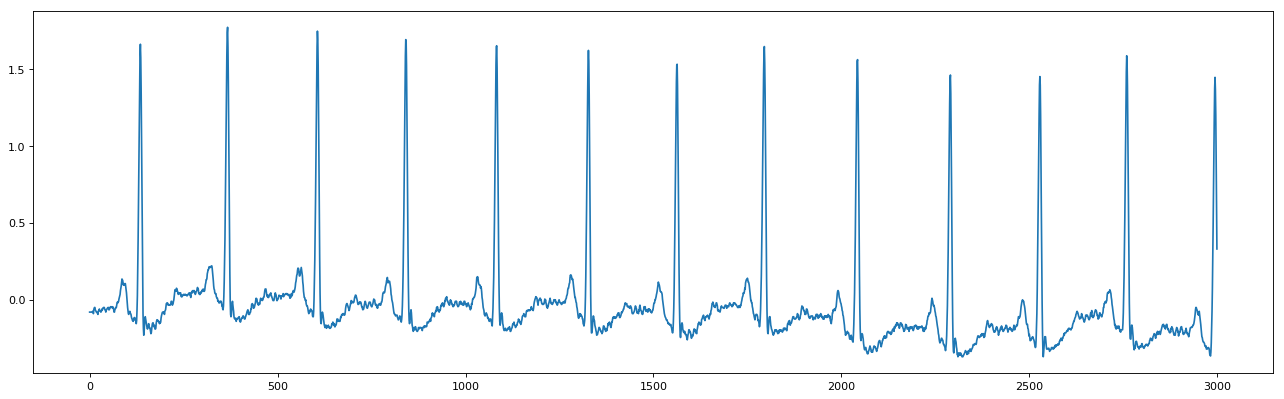

In [27]:
# 测试数据集的读取情况

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(testingSet['234']['lead0'][:3000])
plt.show()

# Data Denoising

## Baseline Wander Removal

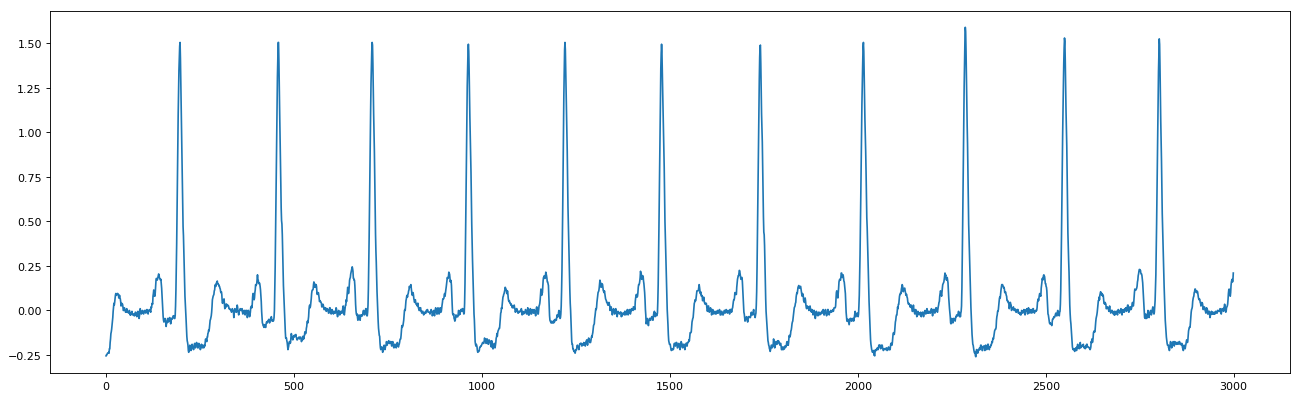

In [12]:
for k, v in testingSet.items():
    first_filtered = medfilt(v['lead0'],71)
    second_filtered = medfilt(first_filtered,215)
    v['lead0'] = v['lead0'] - second_filtered

    first_filtered = medfilt(v['lead1'],71)
    second_filtered = medfilt(first_filtered,215)
    v['lead1'] = v['lead1'] - second_filtered

# 测试数据集的去噪情况

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(testingSet['105']['lead0'][:3000])
plt.show()

## High Frequency Noise Removal in Use of Wavelets Transformation

In [13]:
def wt(index_list,wavefunc,lv,m,n):   # 打包为函数，方便调节参数。  lv为分解层数；index_list为待处理序列；wavefunc为选取的小波函数；m,n则选择了进行阈值处理的小波系数层数
   
    # 分解
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   # 按 level 层分解，使用pywt包进行计算， cAn是尺度系数 cDn为小波系数

    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn函数

    # 去噪过程
    for i in range(m,n+1):   # 选取小波系数层数为 m~n层，尺度系数不需要处理
        cD = coeff[i]
        for j in range(len(cD)):
            Tr = np.sqrt(2*np.log(len(cD)))  # 计算阈值
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) - Tr  # 向零收缩
            else:
                coeff[i][j] = 0   # 低于阈值置零

    # 重构
    denoised_index = pywt.waverec(coeff,wavefunc)
    return denoised_index

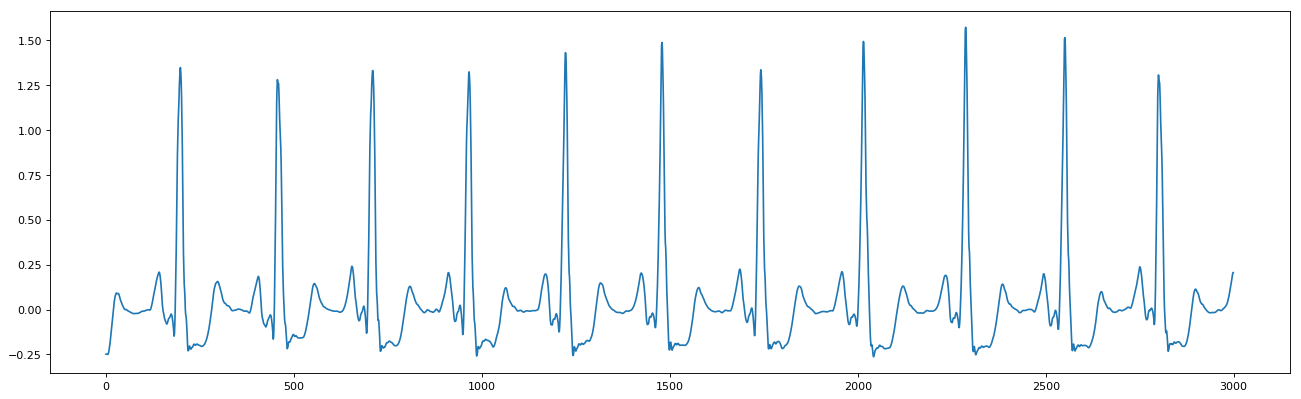

In [14]:
for k, v in testingSet.items():
    v['lead0'] = wt(v['lead0'],'db4',4,2,4)
    v['lead1'] = wt(v['lead1'],'db4',4,2,4)

# 测试数据集的去噪情况

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(testingSet['105']['lead0'][:3000])
plt.show()

# Save Cleaned Data to CSV

In [15]:
headers = ['lead0', 'lead1', 'annIdx', 'annType']

for k, v in testingSet.items():
    df1 = pd.DataFrame({ 'lead0': testingSet[k]['lead0'], 'lead1': testingSet[k]['lead1']})
    df1.to_csv('Cleaned TestingSet/' + k + '_lead.csv', index=False)
    
    df2 = pd.DataFrame({ 'annIdx': testingSet[k]['annIdx'], 'annType': testingSet[k]['annType']})
    df2.to_csv('Cleaned TestingSet/' + k + '_ann.csv', index=False)

In [16]:
# 测试存储情况
df_lead = pd.read_csv('Cleaned TestingSet/105_lead.csv')
df_ann = pd.read_csv('Cleaned TestingSet/105_ann.csv')
df_lead
df_ann

,annIdx,annType
0,67,+
1,197,N
2,459,N
3,708,N
4,965,N
5,1222,N
6,1479,N
7,1741,N
8,2015,N
9,2287,N


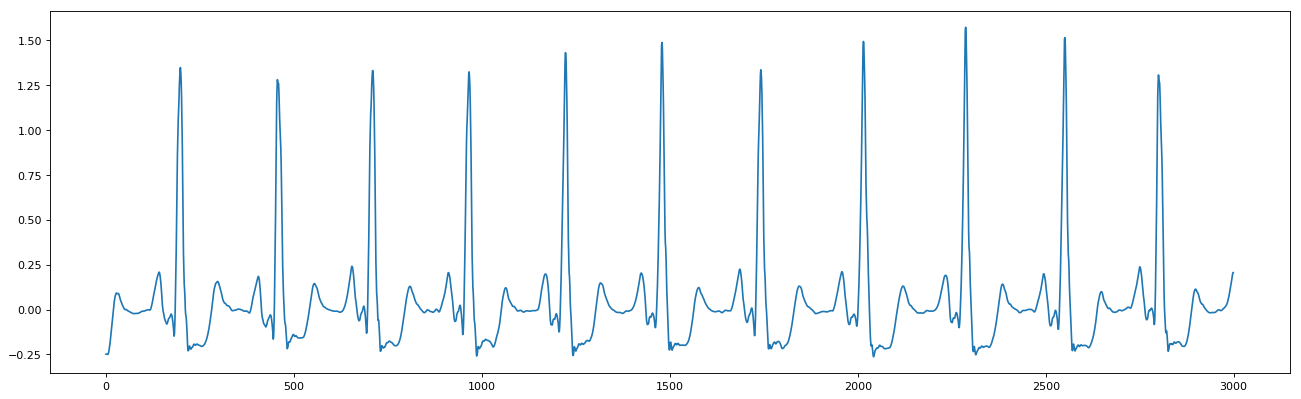

In [17]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(df_lead['lead0'][:3000])
plt.show()